In [906]:
import numpy as np
import pandas as pd
import itertools
import random
from tqdm import tqdm

from hmmlearn import hmm
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

import scipy.optimize
from scipy.interpolate import interp1d

from ast import literal_eval

import matplotlib.pyplot as plt

In [744]:
plt.style.use('seaborn-v0_8')
plt.rcParams["grid.linestyle"] = "--"

plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.shadow'] = True
plt.rcParams['legend.facecolor'] = "lavender"

In [745]:
def preprocess_csv(filename):
    columns_to_eval = [
        "global_mouse_position",
        "button_cooldown_times",
        "logical_frames_since_last_button_press",
        "global_position",
        "velocity",
        "fruits_cut_this_frame_list",
        "fruits_hit_ninjas_ass_this_frame_list",
        "fruits_on_screen_this_frame_list",
        "fruits_spawned_this_frame_list",
        "stupid_fucking_fruits_that_died_this_frame_list",
    ]

    df = pd.read_csv(filename, converters={column: literal_eval for column in columns_to_eval})

    df["fruits_spawned_num"] = df["fruits_spawned_this_frame_list"].str.len()
    df["fruits_on_screen_num"] = df["fruits_on_screen_this_frame_list"].str.len()
    df["fruits_hit_num"] = df["fruits_hit_ninjas_ass_this_frame_list"].str.len()
    df["fruits_missed_num"] = df["stupid_fucking_fruits_that_died_this_frame_list"].str.len()

    projectiles = ["Apple", "Banana", "Grape", "Pineapple", "Watermelon", "Coconut", "Cherry"]

    df["fruit_name_spawned"] = df["fruits_spawned_this_frame_list"].apply(lambda x: projectiles.index(x[0]["name"]) if len(x) != 0 else -1)

    for butt in ["b1", "b2", "b3", "b4"]:
        df[butt] = df["button_cooldown_times"].apply(lambda j: j[butt])

    general_needed = [
        "cheat_flag",
        "frame_count",
        "session_id",
        "score",
        "combo",
        "is_combo_going",
        "time_left_seconds",
        "can_dash",
    ]
    buttons_needed = [
        "b1", "b2", "b3", "b4",
    ]

    df = df[general_needed + buttons_needed]
    df[general_needed] = df[general_needed].astype(int)

    return df

In [746]:
df = preprocess_csv("train_data/gt/fair.csv")
df.head()

,cheat_flag,frame_count,session_id,score,combo,is_combo_going,time_left_seconds,can_dash,b1,b2,b3,b4
0,0,1,1702497524,0,0,0,49,1,0.0,0.0,0.0,0.0
1,0,2,1702497524,0,0,0,49,1,0.0,0.0,0.0,0.0
2,0,3,1702497524,0,0,0,49,1,0.0,0.0,0.0,0.0
3,0,4,1702497524,0,0,0,49,1,0.0,0.0,0.0,0.0
4,0,5,1702497524,0,0,0,49,1,0.0,0.0,0.0,0.0


In [747]:
df_groups = df.groupby("session_id")

# Estimate game length

In [748]:
duration_per_game = df["session_id"].value_counts()
duration_per_game

session_id
1702497863    10796
1702497524     8340
1702498045     7908
1702498347     7620
1702498187     3420
1702498264     1390
1702497678       60
Name: count, dtype: int64

In [749]:
mean_game_duration = np.mean(duration_per_game)
std_game_duration = np.std(duration_per_game)

mean_game_duration, std_game_duration

(5647.714285714285, 3723.773881208061)

In [750]:
int(np.abs(np.random.normal(mean_game_duration, std_game_duration)))

4500

# Estimate is combo going

In [751]:
df["is_combo_going"].value_counts(normalize=True)

is_combo_going
0    0.525548
1    0.474452
Name: proportion, dtype: float64

In [752]:
def find_sequence_lengths(bool_array):
    lengths = [len(list(group)) for _, group in itertools.groupby(bool_array)]
    return lengths

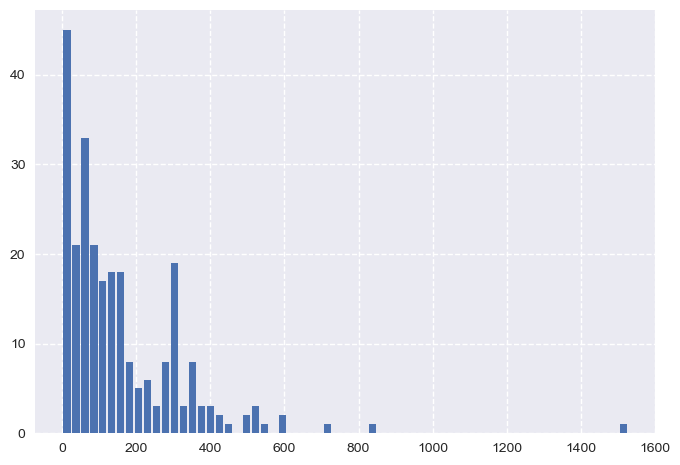

In [753]:
is_combo_seq_length = find_sequence_lengths(df["is_combo_going"].to_numpy().astype(int))

plt.hist(is_combo_seq_length, bins=len(is_combo_seq_length) // 4, rwidth=0.8);

In [754]:
model_is_combo = hmm.CategoricalHMM(n_components=10, n_iter=1_000)
model_is_combo.fit(df["is_combo_going"].to_numpy().reshape(-1, 1))

CategoricalHMM(n_components=10, n_features=2, n_iter=1000,
               random_state=RandomState(MT19937) at 0x107CAF940)

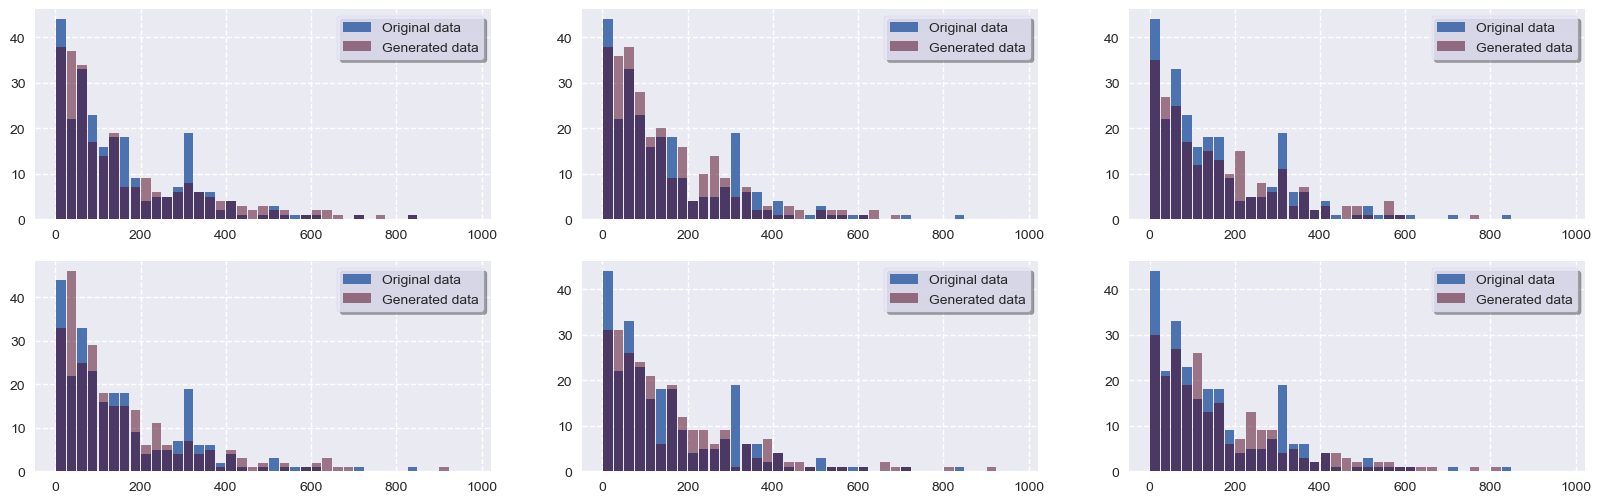

In [755]:
rows, cols = 2, 3
plt.figure(figsize=(20, 6))

for i in range(1, rows * cols + 1):
    synthetic_is_combo, _ = model_is_combo.sample(n_samples=len(df))
    synthetic_is_combo = (synthetic_is_combo.flatten() == 1)
    synthetic_is_combo_seq_length = find_sequence_lengths(synthetic_is_combo)

    bins = np.arange(0, 1_000, 25)
    plt.subplot(rows, cols, i)
    plt.hist(is_combo_seq_length, label="Original data", bins=bins, rwidth=0.9)
    plt.hist(synthetic_is_combo_seq_length, color=(0.3, 0, 0.1, 0.5), label="Generated data", bins=bins, rwidth=0.9)
    plt.legend()

plt.show()

# Estimate combo number

combo
1    0.552807
2    0.240604
3    0.147625
4    0.049901
5    0.005331
6    0.002612
7    0.001120
Name: proportion, dtype: float64

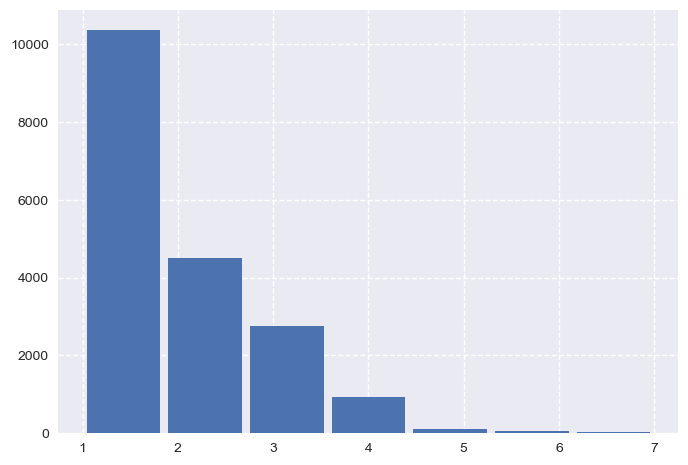

In [756]:
nonzero_combo = df[df["is_combo_going"] == True]["combo"]
plt.hist(nonzero_combo, rwidth=0.9, bins=nonzero_combo.max())
combo_probs = nonzero_combo.value_counts(normalize=True).sort_index()
combo_probs

In [757]:
noise = np.random.normal(1, 0.1, len(combo_probs))
similar_combo_probs = combo_probs.values + 0.0001 / combo_probs.to_numpy() * noise
normed_combo_probs = similar_combo_probs / np.sum(similar_combo_probs)
normed_combo_probs

array([0.4814833 , 0.20990783, 0.12909155, 0.04508012, 0.02250157,
       0.03297811, 0.07895752])

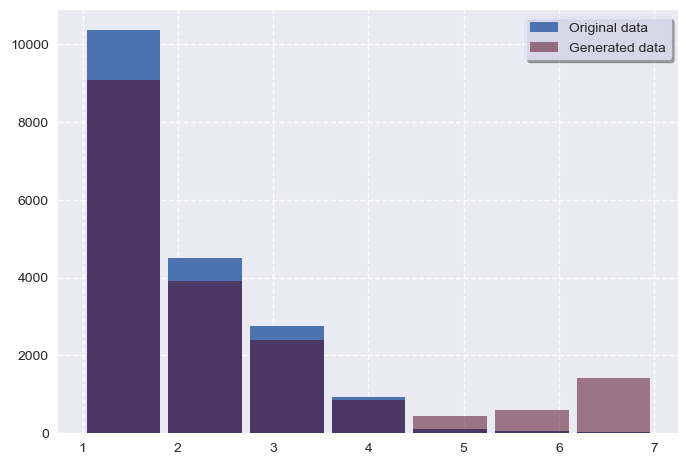

In [758]:
synthetic_combo = np.random.choice(combo_probs.index.to_numpy(), len(nonzero_combo), p=normed_combo_probs)

plt.hist(nonzero_combo, rwidth=0.9, label="Original data", bins=nonzero_combo.max())
plt.hist(synthetic_combo, rwidth=0.9, color=(0.3, 0, 0.1, 0.5), label="Generated data", bins=nonzero_combo.max())
plt.legend();

In [ ]:
def generate_combo(is_combo_seq):
    combo_num = len(is_combo_seq) // 2
    combo_per_seq = np.random.choice(combo_probs.index.to_numpy(), combo_num, p=normed_combo_probs)

    last_tick = 0
    combo_unraveled = []
    is_combo = False

    for i, seq in enumerate(is_combo_seq):
        if is_combo:
            combos = combo_per_seq[i // 2]
            unraveled = np.ones(seq, dtype=int)

            if combos != 1:
                chunk_size = seq // combos
                splitted = np.clip([int(i * chunk_size + np.random.normal(0, 10)) for i in range(1, combos)], 1, seq - 1)

                for intersection_idx in splitted:
                    unraveled[intersection_idx :] += 1

            combo_unraveled.extend(unraveled)

        last_tick += seq
        is_combo = not is_combo

    return combo_unraveled

# Estimate score

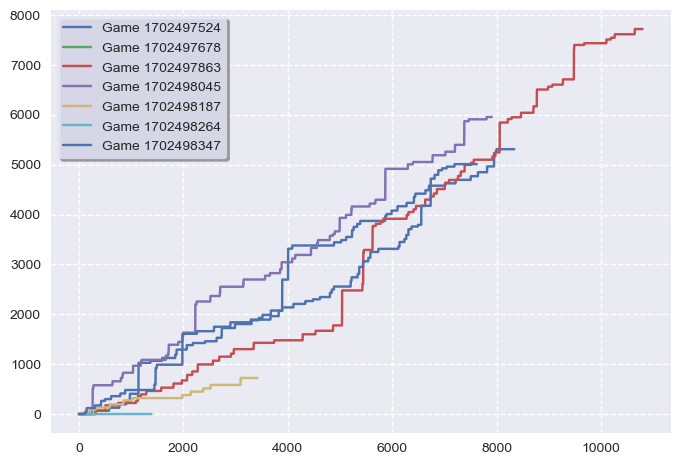

In [759]:
x = []
y = []

for g in df_groups.groups:
    group = df_groups.get_group(g)
    plt.plot(group["frame_count"], group["score"], label=f"Game {g}")

    x.extend(group["frame_count"])
    y.extend(group["score"])
plt.legend()

x = np.array(x)
y = np.array(y)

In [760]:
data_aligned = np.rec.fromarrays([x, y])
data_aligned.sort()

x_train, y_train = data_aligned["f0"], data_aligned["f1"]
x_train = x_train.reshape(-1, 1)

model_score = LinearRegression()
model_score.fit(x_train, y_train)
fitted = model_score.coef_ * x_train  # assume intercept is 0 always

model_score.score(x_train, y_train)

0.9377378398193223

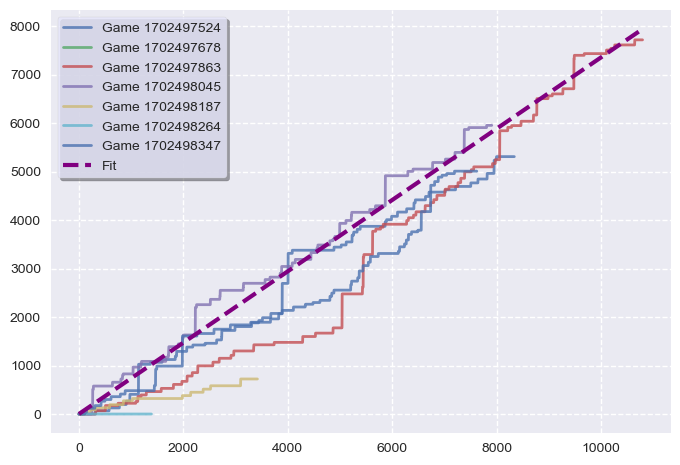

In [761]:
for g in df_groups.groups:
    group = df_groups.get_group(g)
    plt.plot(group["frame_count"], group["score"], label=f"Game {g}", lw=2, alpha=0.8)

plt.plot(x_train, fitted, label="Fit", lw=3, ls="--", color="purple")
plt.legend()

In [762]:
def generate_segment_noise(y_values, num_segments=300, max_step_height=200, noise_std=3):
    staircase_noise = np.zeros_like(y_values)

    for i in range(num_segments):
        start = int(i * len(y_values) / num_segments)
        end = int((i + 1) * len(y_values) / num_segments)
        staircase_noise[start:end] = np.random.normal(300, 30) * np.random.normal(0, noise_std)

    return staircase_noise

/var/folders/br/pkbj6n1x4631dn3pbjc2plgc0000gn/T/ipykernel_8938/349141933.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v = int(max(curr, nex)) + more_noise


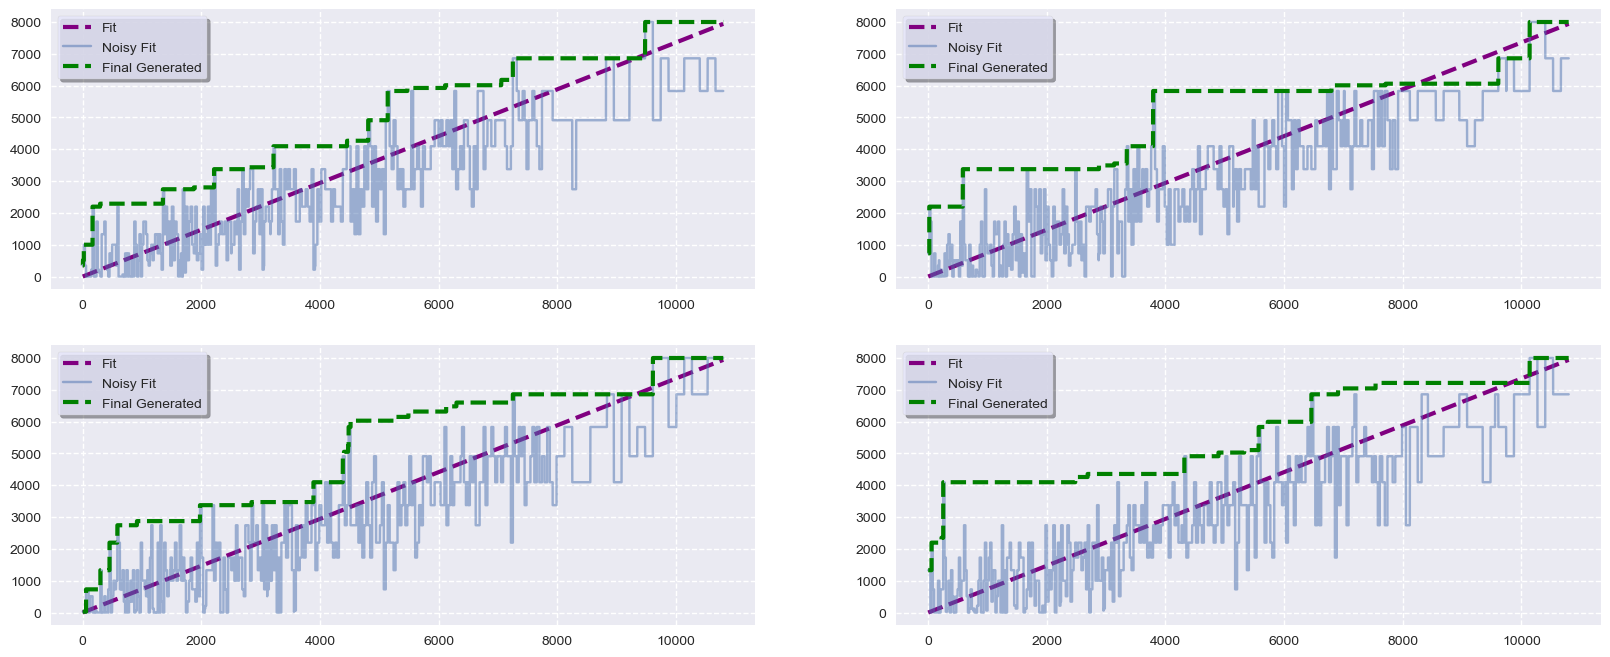

In [763]:
plt.figure(figsize=(20, 8))
rows, cols = 2, 2

for i in range(1, rows * cols + 1):
    plt.subplot(rows, cols, i)
    plt.plot(x_train, fitted, label="Fit", lw=3, ls="--", color="purple")

    fitted_lowered = 0.8 * fitted
    noise = generate_segment_noise(fitted_lowered)
    noisy_fit = fitted_lowered + noise

    bins = np.linspace(0, 200, 500, dtype=int) ** 3
    bins_idx = np.digitize(noisy_fit, bins)
    noisy_fit = bins[bins_idx]

    plt.plot(x_train, noisy_fit, label="Noisy Fit", alpha=0.5)

    for i, (curr, nex) in enumerate(zip(noisy_fit, noisy_fit[1:] + [0])):
        more_noise = np.random.randint(50, 200) * int(np.random.uniform(-0.9, 1.0005))  # very rarely add small value
        v = int(max(curr, nex)) + more_noise
        noisy_fit[i + 1] = v

    plt.plot(x_train, noisy_fit, label="Final Generated", color="green", lw=3, ls="--")
    plt.legend()

In [ ]:
def generate_score(model_score, x_frames):
    fitted_lowered = 0.8 * model_score.coef_ * x_frames
    noise = generate_segment_noise(fitted_lowered)
    noisy_fit = fitted_lowered + noise

    bins = np.linspace(0, 200, 500, dtype=int) ** 3
    bins_idx = np.digitize(noisy_fit, bins)
    noisy_fit = bins[bins_idx]

    for i, (curr, nex) in enumerate(zip(noisy_fit, noisy_fit[1:] + [0])):
        more_noise = np.random.randint(50, 200) * int(np.random.uniform(-0.9, 1.0005))  # very rarely add small value
        v = int(max(curr, nex)) + more_noise
        noisy_fit[i + 1] = v

    return noisy_fit

# Estimate time left sec

/Users/alorthius/anaconda3/envs/big_data/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/alorthius/anaconda3/envs/big_data/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/alorthius/anaconda3/envs/big_data/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/alorthius/anaconda3/envs/big_data/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


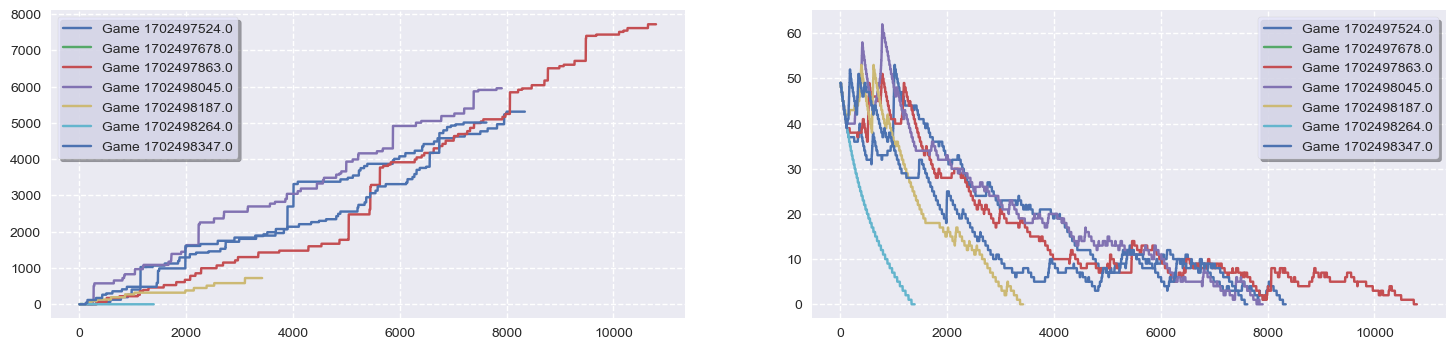

In [764]:
x1 = []
x2 = []
x3 = []
y = []

plt.figure(figsize=(18, 4))
for g in df_groups.groups:

    plt.subplot(1, 2, 1)
    group = df_groups.get_group(g)
    plt.plot(group["frame_count"], group["score"], label=f"Game {group.iloc[0]['session_id']}")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(group["frame_count"], group["time_left_seconds"], label=f"Game {group.iloc[0]['session_id']}")
    plt.legend()

    cor = group["score"].corr(df["time_left_seconds"])

    x1.append(group["frame_count"])
    x2.append(group["combo"])
    x3.append(group["score"])

    y.append(group["time_left_seconds"])

plt.show()

In [765]:
x_train = []
for x in [x1, x2, x3]:
    max_length = max(len(sublist) for sublist in x)
    dict_x = {i: [] for i in range(max_length)}
    for sub in x:
        for i, e in enumerate(sub):
            dict_x[i].append(e)

    x_train.append(np.array(list(itertools.chain(*dict_x.values()))))
x_train = np.array(x_train)


max_length = max(len(sublist) for sublist in y)
dict_y = {i: [] for i in range(max_length)}
for sub in y:
    for i, e in enumerate(sub):
        dict_y[i].append(e)
y_train = np.array(list(itertools.chain(*dict_y.values())))

In [766]:
model_time_left = SVR(kernel="rbf")

model_time_left.fit(x_train.T, y_train)

model_time_left.score(x_train.T, y_train)

0.8637967121896573

In [767]:
def predict_time_left(group_df):
    X = np.array([group_df["frame_count"], group_df["combo"], group_df["score"]])
    pred = model_time_left.predict(X.T)
    last = int(5 * len(pred) / 10)
    weights = 0.5 * (1 - np.cos(np.linspace(0, np.pi, len(pred) - last)))
    pred[last :] = pred[last :] * (1 - weights)
    return pred

In [768]:
chunk = df_groups.get_group(list(df_groups.groups.keys())[0])
fitted = model_time_left.predict(chunk[["frame_count", "combo", "score"]].to_numpy())
fitted_converged = predict_time_left(chunk)

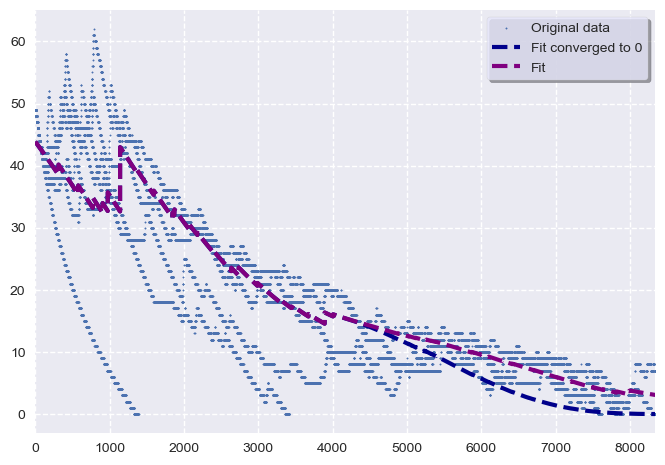

In [769]:
plt.scatter(x_train[0], y_train, s=1, label="Original data")

plt.plot(chunk["frame_count"], fitted_converged, lw=3, ls="--", color="darkblue", label="Fit converged to 0")
plt.plot(chunk["frame_count"], fitted, lw=3, ls="--", color="purple", label="Fit")

plt.xlim((0, np.max(chunk["frame_count"])))
plt.legend();

# Estimate buttons cd

In [770]:
chunk["b1"].value_counts(normalize=True).sort_index()

b1
0.000000    0.011391
0.001410    0.000240
0.001450    0.000120
0.002269    0.000120
0.002606    0.000120
              ...   
3.496356    0.000240
3.496807    0.000120
3.497081    0.000240
3.497971    0.000120
3.499921    0.000240
Name: proportion, Length: 3971, dtype: float64

In [771]:
b1_p = len(chunk[np.isclose(chunk["b1"], 3, atol=0.1)]) / len(chunk)
b1_p

0.42841726618705034

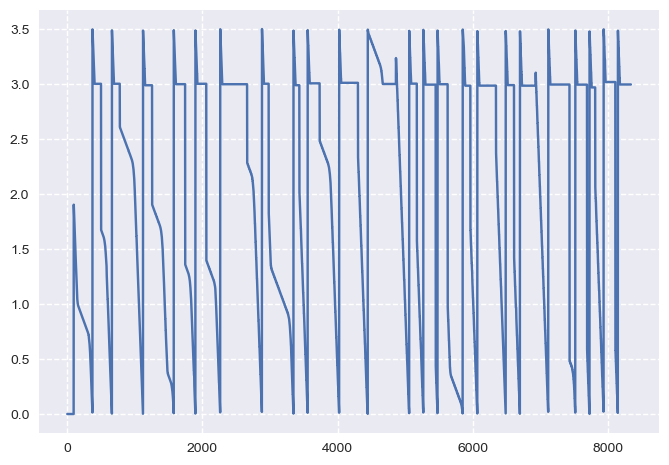

In [772]:
plt.plot(chunk["b1"][:10000])

In [773]:
# estimated in notebook data_experiments.ipynb

b1_dict = {
    "amp": 1.0055680189205751,
    "omega": 0.030572740827393606,
    "phase": -0.9869339649207202,
}

b2_dict = {
    "amp": 1.0676529865925386,
    "omega": 0.03004968906527392,
    "phase": -0.9921447309522731,
}

b3_dict = {
    "amp": 0.6691869538977475,
    "omega": 0.029821823468847045,
    "phase": -0.7704732498233992,
}

b4_dict = {
    "amp": 0.468273171092243,
    "omega": 0.03018532477043755,
    "phase": -0.5968081812395676,
}

In [899]:
def generate_butt_cd(frames_space, butt: str):
    butt_dict = eval(f"{butt}_dict")
    butt_cd = np.clip(
        np.sum([butt_dict["amp"] * np.sin(butt_dict["omega"] * k * frames_space - butt_dict["phase"]) for k in range(0, 10, 1)], axis=0)
        + np.abs(np.random.normal(0, 0.1, len(frames_space)))
        + np.random.exponential(0.1, len(frames_space)),
        0.1, 3.5)

    # bins = np.linspace(0, 3.5, 5)
    # bins_idx = np.digitize(butt_cd, bins)
    # butt_cd = bins[bins_idx - 1]
    #
    # for i, (curr, nex) in enumerate(zip(butt_cd, butt_cd[1:] + [0])):
    #     # more_noise = np.random.randint(50, 200) * int(np.random.uniform(-0.9, 1.0005))  # very rarely add small value
    #     v = int(np.mean([curr, nex]))
    #     butt_cd[i + 1] = v

    return butt_cd

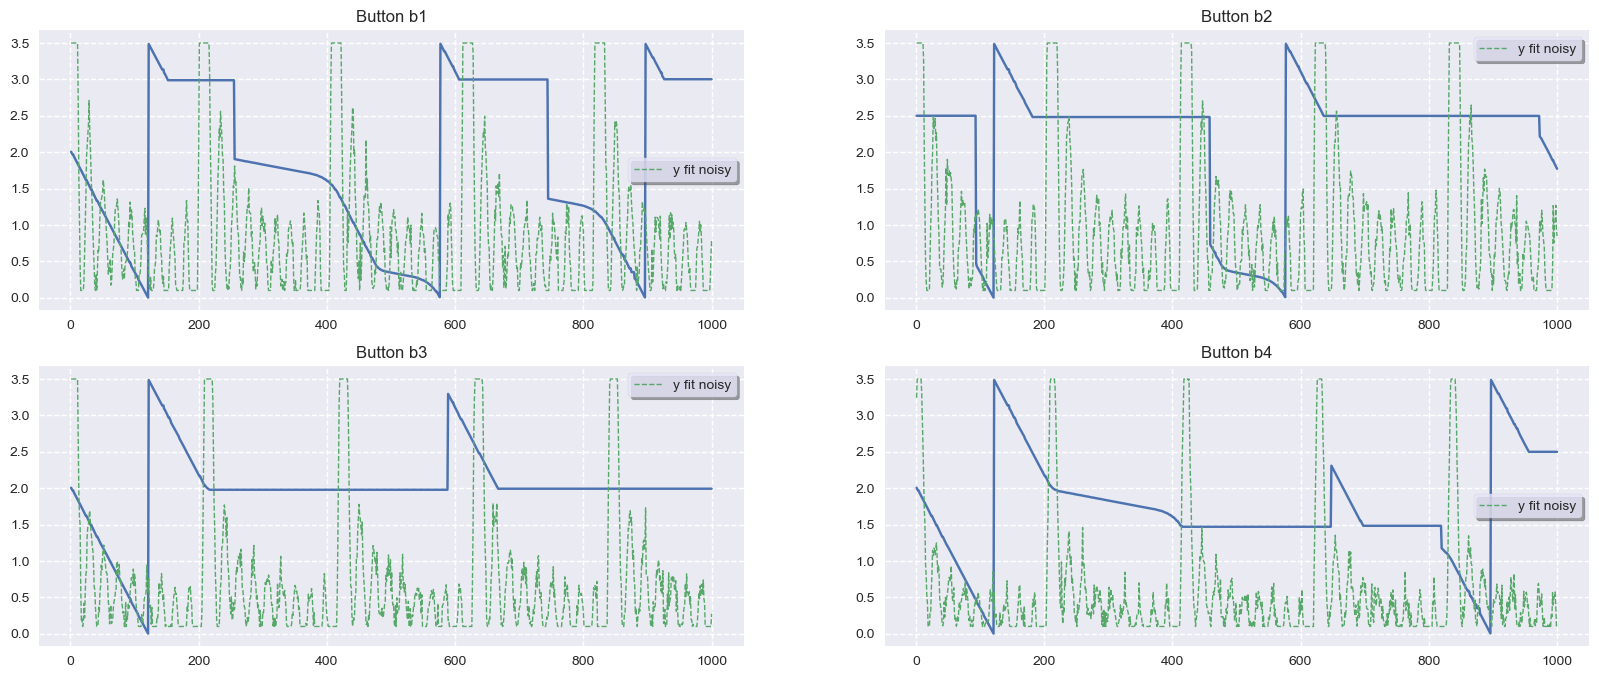

In [900]:
plt.figure(figsize=(20, 8))
for i, butt in enumerate(["b1", "b2", "b3", "b4"]):
    plt.subplot(2, 2, i + 1)

    tt = df["frame_count"][:1000]

    yynoise = df[butt][1000:2000]
    plt.plot(tt, yynoise)

    noisy_fitted = generate_butt_cd(tt, butt)
    plt.plot(tt, noisy_fitted, label="y fit noisy", linewidth=1, ls="--")

    plt.legend(loc="best")
    plt.title(f"Button {butt}")

# Estimate whether can dash

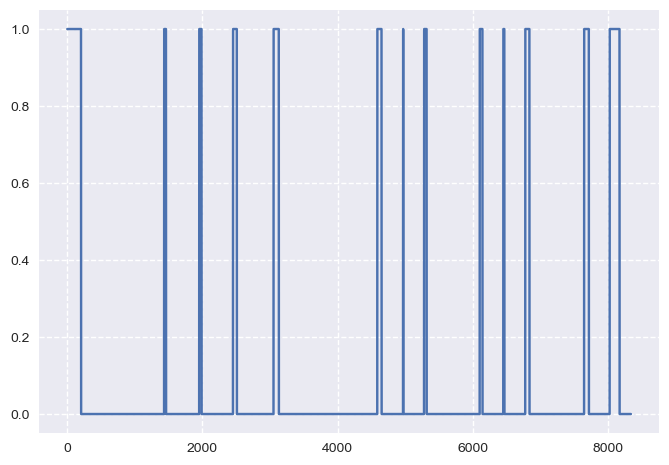

In [776]:
plt.plot(chunk["can_dash"])
df["can_dash"].value_counts(normalize=True);

In [777]:
dash_seq = find_sequence_lengths(df["can_dash"])

mean_dash_available = int(np.mean(dash_seq[::2]))
mean_dash_available

76

In [778]:
dash_prob = mean_dash_available / (np.sum(dash_seq))
dash_prob

0.0019223959123792179

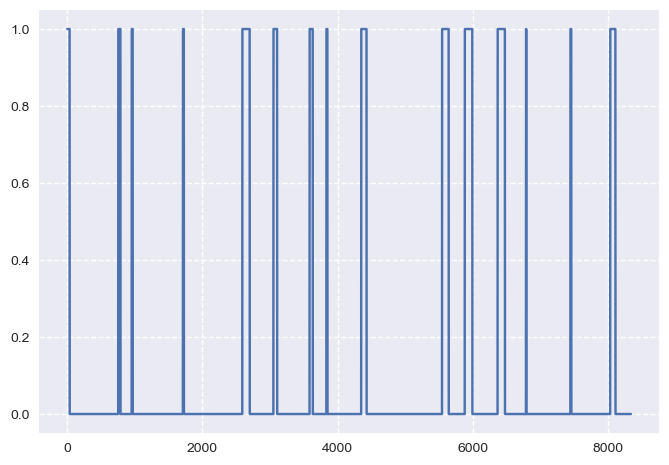

In [780]:
def generate_can_dash(length, probability, duration_range):
    boolean_sequence = np.zeros((length,), dtype=int)

    i = 0
    while i < len(boolean_sequence):
        if np.random.rand() < probability:
            duration = np.random.randint(*duration_range)
            boolean_sequence[i:i+duration] = 1
            i += duration
            i += np.random.randint(120, 200)
        else:
            i += 1

    # game begins with dash available, so fill with 1 and some proceeding amount of 0
    start_l = np.random.randint(*duration_range)
    boolean_sequence[:start_l] = 1
    start_z = np.random.randint(120, 200)
    boolean_sequence[start_l : start_z] = 0

    return boolean_sequence



boolean_sequence = generate_can_dash(
    len(chunk),
    dash_prob,
    (1, 2 * mean_dash_available)
)
plt.plot(boolean_sequence)

# Final Generation

In [911]:
N_games = 50  # number of synthetic games to generate

In [912]:
synthetic_df = pd.DataFrame().reindex_like(df).dropna()
synthetic_df

,cheat_flag,frame_count,session_id,score,combo,is_combo_going,time_left_seconds,can_dash,b1,b2,b3,b4


In [913]:
generated_dfs = []

for game_idx in tqdm(range(N_games)):
    game_df = synthetic_df.copy()  # its empty

    game_duration = int(np.abs(np.random.normal(mean_game_duration, std_game_duration)))

    session = random.randint(10 ** 9, (10 ** 10) - 1)
    game_df["session_id"] = [session] * game_duration

    cheat_flag = 0
    game_df["cheat_flag"] = [cheat_flag] * game_duration

    frame_count = np.arange(1, game_duration + 1, 1)
    game_df["frame_count"] = frame_count

    is_combo, _ = model_is_combo.sample(n_samples=game_duration)
    game_df["is_combo_going"] = is_combo.flatten()

    combo_seq_length = find_sequence_lengths(is_combo)
    combo_seq = generate_combo(combo_seq_length)

    game_df["combo"] = 0
    game_df.loc[game_df["is_combo_going"] == 1, "combo"] = combo_seq

    score = generate_score(model_score, frame_count)
    game_df["score"] = score

    time_left = predict_time_left(game_df)
    game_df["time_left_seconds"] = time_left

    can_dash = generate_can_dash(game_duration, dash_prob, (1, 2 * mean_dash_available))
    game_df["can_dash"] = can_dash

    for butt in ["b1", "b2", "b3", "b4"]:
        butt_cd = generate_butt_cd(frame_count, butt)
        game_df[butt] = butt_cd

    generated_dfs.append(game_df)

100%|██████████| 50/50 [05:35<00:00,  6.72s/it]


In [914]:
pd.concat(generated_dfs).to_csv(f"train_data/synthetic/fair_{N_games}-games.csv")